# Denoising of Single EM Image

**Created on:** 23/10/2024  
**Author:** Dmitry Chezganov  

This notebook processes a single Electron Microscopy (EM) image by applying denoising techniques using custom neural network-based functions. The NN was develoed by Ivan Lobato and can be found at [https://github.com/Ivanlh20/tk_r_em](https://github.com/Ivanlh20/tk_r_em) as well as the details of installation procedure.
 
 The main steps include:

- Importing the necessary libraries and custom functions (`NN_denois_functions` and `hyperspy`)
- Specifying the image file to be denoised and setting the output directory for results
- Configuring the maximum image size for GPU-based denoising
- Loading and visualizing the image before and after denoising
- Saving images in various formats

The goal of this notebook is to improve the quality of the EM image for further analysis by removing noise while preserving essential details.



## Import libraries

In [33]:
import NN_denois_functions as nn
import hyperspy.api as hs
import tensorflow as tf

## Indicate path to the .dm3 image file and path to save results

In [ ]:
# * Specify the file to denoise
image_file = '/images/dm3/16.55.37 Scanning Acquire_0.dm3'
# * Specify the folder to save the results
output_folder = '/images/dm3/denoising_single image/'

# * Output folder
folder_to_save = nn.make_folder(output_folder, 'denoised_images')

## Use patch-based method if x or y dimension is larger than max_size_gpum

In [37]:
max_size_gpu = 1024
print(f'Maximum image size which fits into GPU memory: {max_size_gpu}')

Maximum image size which fits into GPU memory: 1024


## Image loading

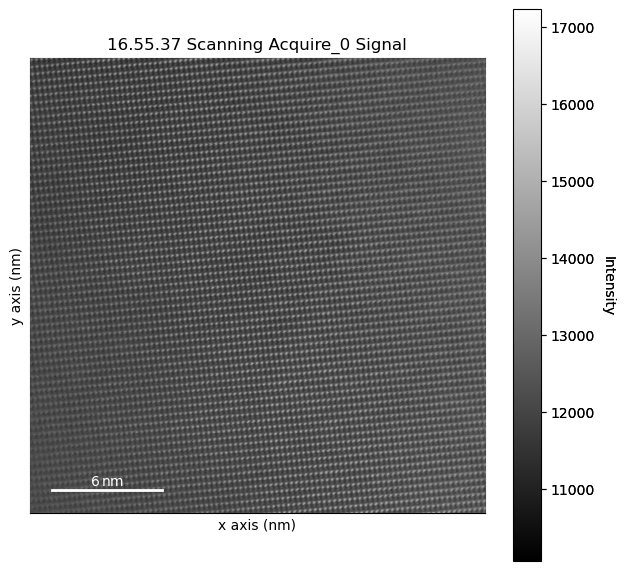

In [39]:
%matplotlib inline
s = nn.hs.load(image_file)
# s.inav[1].plot()
s.plot()

## Run denoising and saving in various formats
In principle it should work for any EM image if proper denoising model is selected and modification of the code made for specific file type to extract relevant values of Mag, HT, px_size

Model: sfr_hrstem
Loading network...
Denoising images...
Image name: 16.55.37 Scanning Acquire_0
Pixel size: 0.012127635069191456 nm - extracted from dm3 file
Image size: 2048 x 2048
Patch-based denoise...


2024-10-25 10:17:01.791540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 494ms/step


2024-10-25 10:17:19.599168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 8s 8s/step


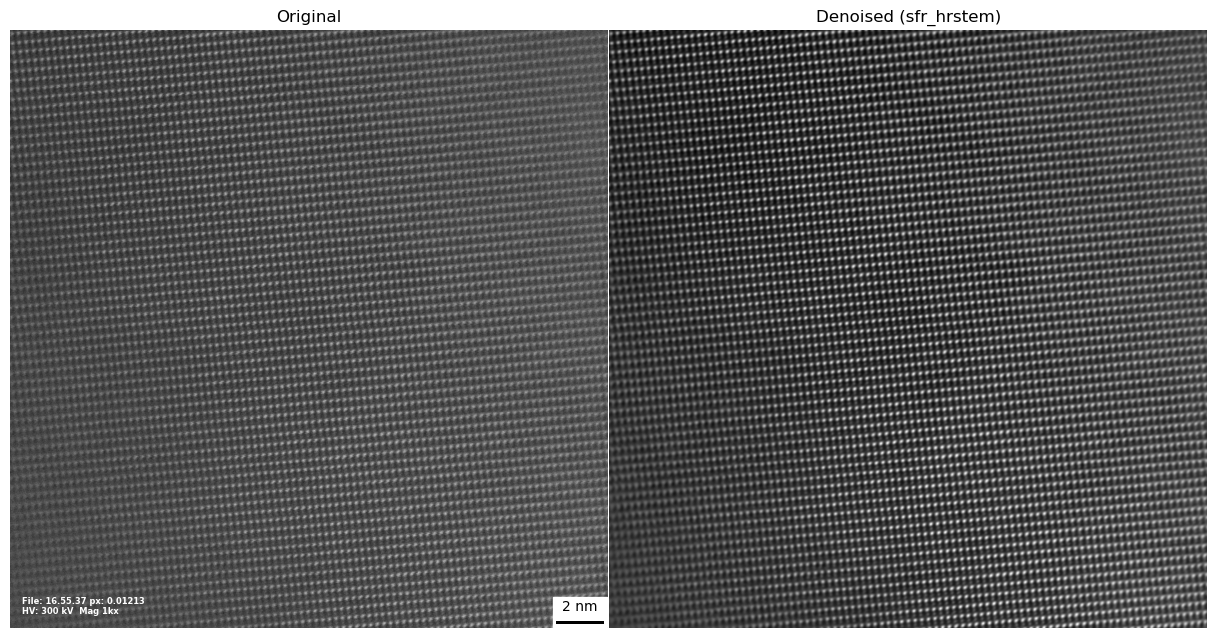

Saved as tiff:  16.55.37 Scanning Acquire_0_denoised
Saved as png:  16.55.37 Scanning Acquire_0_denoised
Saved as tiff:  16.55.37 Scanning Acquire_0_original
Saved as png:  16.55.37 Scanning Acquire_0_original
Time elapsed: 46.37 s
#####################
Denoising is finished!


In [45]:
# time it
import time
start = time.time()

# ! Set GPU ID
nn.fcn_set_gpu_id("0")

# valid_models = ['sfr_hrstem', 'sfr_lrstem', 'sfr_hrsem', 'sfr_lrsem', 'sfr_hrtem', 'sfr_lrtem']
# * Choose denoising model
net_name = 'sfr_hrstem'

# * Load the network
print(f'Model: {net_name}')
print('Loading network...')
r_em_nn = nn.load_network(net_name)

print('Denoising images...')
filename = nn.os.path.basename(image_file)
filename= filename[:-4]
print(f'Image name: {filename}')
# short name to put on the images
filename_short = filename.split('_')[0]

#* Read image
img = hs.load(image_file)
# #* we use here artificial units and HT, mag is from the file name, px_size is unknown, can be changed later
unit = 'nm'
HT = 300
# change this value to the correct one or modify code to extract it from the file name
mag_trimmed = 1
# mag = img.metadata.get_item('General.title').split('_')[2]
# # px_size = 1

# if mag.endswith('kx'):
#     mag_trimmed = int(mag[:-2])
# else:
#     mag_trimmed = str(mag[:-2])
# #! extraction of correct px size from the calibration file: can be xls list or extracted from file
# #* choose the option for pixel size extraction
# # px_size_chose_flag = 1 # for xls
px_size_chose_flag = 2 # for extracted from dm3 file

if px_size_chose_flag == 1:
    if mag_trimmed in calibration['Magnification [kx]'].values:
        print(f'Mag {mag} is in the calibration file')
        row_index = calibration[calibration['Magnification [kx]'] == mag_trimmed].index
        if not row_index.empty:
            # Extract px_size value
            px_size = calibration.loc[row_index[0], 'Pixel size [nm/px]']
            print(f'Px_size for for Mag {mag}: {px_size}')

    else:
        print(f'Mag {mag} is not in the calibration file')
        px_size = 'unknown'
else:
    px_size = img.axes_manager['x'].scale
    unit = img.axes_manager['x'].units
    if unit=='µm':
        px_size = px_size*10**3
        unit = 'nm'
        print(f'Pixel size: {px_size} {unit} - extracted from dm3 file but coverted from µm to nm')
    else:
        print(f'Pixel size: {px_size} {unit} - extracted from dm3 file')

# image=img.inav[0].data
image = img.data
# * Check image size
nx, ny = image.shape
print(f'Image size: {nx} x {ny}')
# expand dimensions since for some reason it is needed
# image = nn.np.expand_dims(img, axis=(0, -1)) # this is used for denoising
# * Denoise image
denoised_image = nn.denoise_image(image = image,
                                    net = r_em_nn, 
                                    nx=nx, 
                                    ny=ny, 
                                    max_size_gpu = max_size_gpu
                                    )
# * Plot comparison
nn.plot_original_vs_denoised(original_image=image,
                                denoised_image=denoised_image,
                                file_name=filename_short,
                                net_name=net_name,
                                cmap='gray',
                                save_path=folder_to_save,
                                show=True, 
                                scale=px_size,
                                units=unit,
                                px_size=px_size,
                                HT=HT,
                                mag=mag_trimmed
                                )
# ! Check options for image saving
# * Flags
save_32bit_tif = True
save_16bit_tif_png_scalerbar_original = True
save_16bit_tif_png_scalerbar_denoised = True
save_fft = True

# * Save denoised image
# save denoised images as 32 tif
if save_32bit_tif==True:
    nn.save_tif_32bit_image_denoised(image=denoised_image,
                                        file_name=filename, 
                                        outputpath=folder_to_save, 
                                        pixelsize=px_size,
                                        unit=unit,
                                        model_name=net_name
                                        )
    # save original images as 32 tif
    nn.save_tif_32bit_image_original(image=image,
                                        file_name=filename, 
                                        outputpath=folder_to_save, 
                                        pixelsize=px_size,
                                        unit=unit,
                                        model_name=net_name
                                        )
if save_16bit_tif_png_scalerbar_denoised==True:
# save denoised images as 16bit tif and 8bit png with scalebar
    nn.save_tif_png_16bit_image_with_scalebar(image=denoised_image,
                                            save_path_tif16bit=folder_to_save,
                                            save_path_png=folder_to_save,
                                            file_name=filename+'_denoised',
                                            px_size=px_size,
                                            mag=mag,
                                            HT=HT,
                                            units=unit,
                                            show=False
                                            )
if save_16bit_tif_png_scalerbar_original==True:
# save original images as 16bit tif and 8bit png with scalebar
    nn.save_tif_png_16bit_image_with_scalebar(image=image,
                                            save_path_tif16bit=folder_to_save,
                                            save_path_png=folder_to_save,
                                            file_name=filename+'_original',
                                            px_size=px_size,
                                            mag=mag,
                                            HT=HT,
                                            units=unit,
                                            show=False
                                            )
time_elapsed = time.time() - start
print(f'Time elapsed: {time_elapsed:.2f} s')

print('#####################')
print('Denoising is finished!')